In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'

# Debt Market Model

The purpose of this notebook is to configure and simulate the full CDP and APT system model, using the historical Ethereum price as a driver, under different PI controller settings - enabled, disabled, `kp` and `ki`.

# Setup and Dependencies

In [2]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Force reload of project modules, sometimes necessary for Jupyter kernel
%load_ext autoreload
%autoreload 2

# Display cadCAD version for easy debugging
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages
Requires: funcy, pathos, fn, pandas
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import all shared dependencies and setup
from shared import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import plotly.io as pio
# pio.renderers.default = "png"

# Historical MakerDAO Dai debt market activity

In [4]:
# Import the historical MakerDAO market data CSV file
from models.system_model_v3.model.params.init import debt_market_df
debt_market_df

seconds_passed    rho_star   beta         p             Q  \
date                                                                    
2018-04-01           86400  383.822378  0.005  0.996472  1.304176e+05   
2018-04-02           86400  386.787115  0.005  0.999184  1.344705e+05   
2018-04-03           86400  402.818424  0.005  0.993012  1.347840e+05   
2018-04-04           86400  392.545993  0.005  0.989616  1.364970e+05   
2018-04-05           86400  379.389608  0.005  1.002888  1.378249e+05   
...                    ...         ...    ...       ...           ...   
2019-09-26           86400  167.637314  0.125  1.021405  1.525944e+06   
2019-09-27           86400  167.347085  0.125  1.007346  1.529959e+06   
2019-09-28           86400  174.289775  0.125  1.011006  1.528450e+06   
2019-09-29           86400  171.054119  0.105  1.013604  1.529013e+06   
2019-09-30           86400  173.096419  0.105  1.007126  1.531726e+06   

                     v_1     v_2 + v_3            u_1     u_2 + u_3  \
date                                                                  
2018-04-01   3575.828421     75.286089  397538.457500  3.369517e+04   
2018-04-02   4158.239991    105.338665  206636.000000  1.195705e+04   
2018-04-03    976.262655    662.782265  321120.330000  2.221112e+05   
2018-04-04   1781.667763     68.592053  217219.126161  2.063823e+05   
2018-04-05   1449.263202    121.398587  411720.500000  4.433695e+04   
...                  ...           ...            ...           ...   
2019-09-26  56696.770732  29566.578527  807916.984507  1.585480e+06   
2019-09-27   7598.158072   3582.812664  608760.677317  6.367461e+05   
2019-09-28    876.961579   2386.452089  225195.561593  1.452312e+05   
2019-09-29   2263.584945   1700.812508  135777.379105  1.699417e+05   
2019-09-30   4436.484054   1722.801186  684875.199701  1.920650e+05   

                     u_2  ...           u_3           w_3     w_2 + w_3  \
date                      ...                                             
2018-04-01  3.346177e+04  ...  2.334048e+02  4.713235e-02      6.804199   
2018-04-02  1.195705e+04  ...  2.915840e-09  4.652248e-13      1.907757   
2018-04-03  2.221112e+05  ...  0.000000e+00  0.000000e+00    128.782844   
2018-04-04  2.063823e+05  ...  3.492460e-10  2.725929e-13    161.085196   
2018-04-05  4.433695e+04  ...  1.862645e-09  2.339915e-13      5.569751   
...                  ...  ...           ...           ...           ...   
2019-09-26  1.515115e+06  ...  7.036438e+04  2.984212e+03  67241.524162   
2019-09-27  6.366783e+05  ...  6.779026e+01  7.681557e-01   7215.198255   
2019-09-28  1.452062e+05  ...  2.500000e+01  8.480860e-02    492.674170   
2019-09-29  1.699335e+05  ...  8.108662e+00  1.231760e-01   2581.527301   
2019-09-30  1.920636e+05  ...  1.400000e+00  9.118447e-03   1250.952959   

                     D_1           D_2           w_1             D  \
date                                                                 
2018-04-01  1.937743e+07  9.035786e+03    264.904620  1.938647e+07   
2018-04-02  1.957211e+07  9.301446e+03    267.568355  1.958141e+07   
2018-04-03  1.967112e+07  9.441589e+03    268.924904  1.968056e+07   
2018-04-04  1.968196e+07  9.549578e+03    269.074899  1.969151e+07   
2018-04-05  2.004934e+07  9.818105e+03    274.096521  2.005916e+07   
...                  ...           ...           ...           ...   
2019-09-26  7.957442e+07  4.562428e+06  27167.708945  8.413685e+07   
2019-09-27  7.954644e+07  4.582358e+06  27145.743151  8.412880e+07   
2019-09-28  7.962640e+07  4.609044e+06  27177.983765  8.423545e+07   
2019-09-29  7.959224e+07  4.629498e+06  23036.315844  8.422174e+07   
2019-09-30  8.008505e+07  4.651424e+06  23176.738113  8.473647e+07   

                  C_star  p_star  p_ema_10  
date                                        
2018-04-01  5.005718e+07       1  1.001429  
2018-04-02  5.201145e+07       1  1.001174  
2018-04-03  5.429346e+07       1  1.001308  
2018-04-04  5.358136e+07  

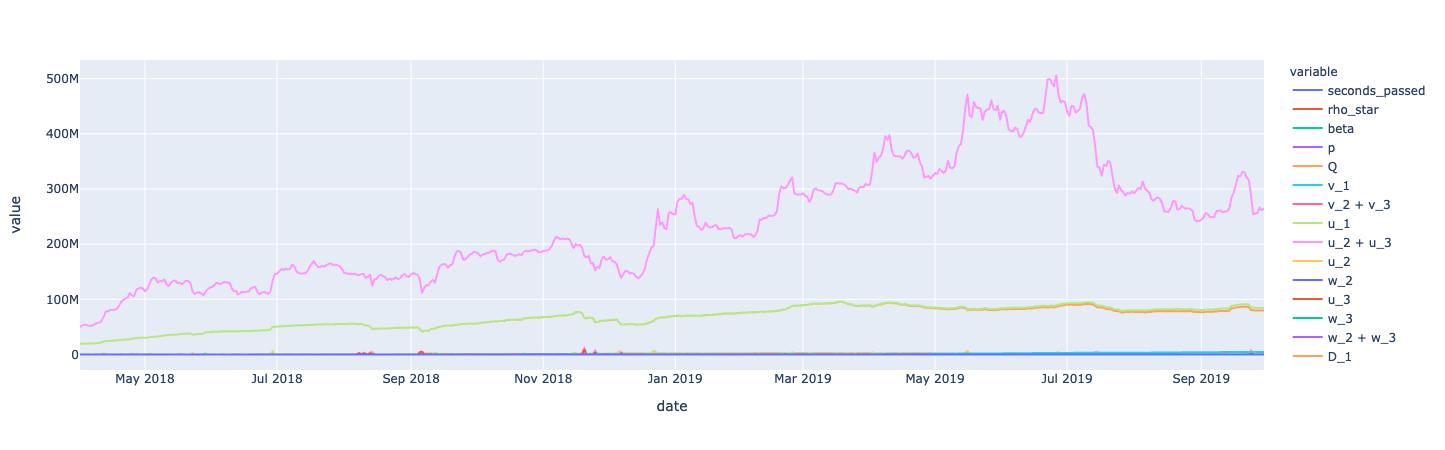

In [5]:
# Plot the full set of historical data over time
debt_market_df.plot()

# Model Configuration

In [6]:
from models.system_model_v3.model.state_variables.init import state_variables

state_variables.update({})


130417.5685990905
189872.3149593018
29727.37318010564
29727.37318010564


19377432.0069828
42320205.44783997
16068921.349645888
6873852.091211276

130417.5685990905 33371454.249511395


In [7]:
from models.system_model_v3.model.params.init import params

# Update the default parameter values
params_update = {
    'controller_enabled': [False],
    'kp': [1e-7], # 5e-7 # proportional term for the stability controller: units 1/USD
    'ki': [lambda control_period=3600: -1e-7 / control_period], # integral term for the stability controller: units 1/(USD*seconds)
}

params.update(params_update)

# Simulation Execution

In [8]:
# Set the number of simulation timesteps, with a maximum of `len(debt_market_df) - 1`
SIMULATION_TIMESTEPS = len(debt_market_df) - 1

In [9]:
# Create a wrapper for the model simulation, and update the existing parameters and initial state
system_simulation = ConfigWrapper(system_model_v3, T=range(SIMULATION_TIMESTEPS), M=params, initial_state=state_variables)

In [10]:
del configs[:] # Clear any prior configs
system_simulation.append() # Append the simulation config to the cadCAD `configs` list
(simulation_result, _tensor_field, _sessions) = run(drop_midsteps=False) # Run the simulation


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (547, 33, 1, 46)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Performing arb. UNI -> CDP
Over collateralized!
Performing arb. CDP -> UNI
False
True
True
True
True
Over collateralized!
Performing arb. CDP -> UNI
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

# Simulation Analysis

In [11]:
# Add new columns to dataframe
simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)
simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)

# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

simulation_result

index events                                        cdp_metrics  \
0         0   None                                                 {}   
1         1   None                                                 {}   
2         2   None                                                 {}   
3         3   None                                                 {}   
4         4   None                                                 {}   
...     ...    ...                                                ...   
8748   8748     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
8749   8749     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
8750   8750     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
8751   8751     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
8752   8752     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   

     optimal_values  timedelta  cumulative_time  timestamp  blockheight  \
0                {}        0.0              0.0 2018-04-01            0   
1                {}        0.0              0.0 2018-04-01            0   
2                {}    86400.0          86400.0 2018-04-02            0   
3                {}    86400.0          86400.0 2018-04-02            0   
4                {}    86400.0          86400.0 2018-04-02            0   
...             ...        ...              ...        ...          ...   
8748             {}    86400.0       47260800.0 2019-09-30            0   
8749             {}    86400.0       47260800.0 2019-09-30            0   
8750             {}    86400.0       47260800.0 2019-09-30            0   
8751             {}    86400.0       47260800.0 2019-09-30            0   
8752             {}    86400.0       47260800.0 2019-09-30            0   

       eth_price                                               cdps  \
0     383.822378                                               None   
1     383.822378                                               None   
2     383.822378                                               None   
3     383.822378                                               None   
4     383.822378                                               None   
...          ...                                                ...   
8748  171.054119     open  time         locked         drawn    ...   
8749  171.054119     open  time         locked         drawn    ...   
8750  171.054119     open  time         locked         drawn    ...   
8751  173.096419     open  time         locked         drawn    ...   
8752  173.096419     open  time         locked         drawn    ...   

      eth_collateral     eth_locked     eth_freed  eth_bitten  v_1  v_2  v_3  \
0      130417.568599  130417.568599      0.000000         0.0  0.0  0.0  0.0   
1      130417.568599  130417.568599      0.000000         0.0  0.0  0.0  0.0   
2      130417.568599  130417.568599      0.000000         0.0  0.0  0.0  0.0   
3      130417.568599  130417.568599      0.000000         0.0  0.0  0.0  0.0   
4      130417.568599  130417.568599      0.000000         0.0  0.0  0.0  0.0   
...              ...            ...           ...         ...  ...  ...  ...   
8748    93223.812522  130417.568599  37193.756077         0.0  0.0  0.0  0.0   
8749    93223.812522  130417.568599  37193.756077         0.0  0.0  0.0  0.0   
8750    93223.812522  130417.568599  37193.756077         0.0  0.0  0.0  0.0   
8751    93223.812522  130417.568599  37193.756077         0.0  0.0  0.0  0.0   
8752    93223.812522  130417.568599  37193.756077         0.0  0.0  0.0  0.0   

      principal_debt     rai_drawn     rai_wiped  rai_bitten  u_1  \
0       3.337145e+07  3.337145e+07  0.000000e+00         0.0  0.0   
1       3.337145e+07  3.337145e+07  0.000000e+00         0.0  0.0   
2       3.337145e+07  3.337145e+07  0.000000e+00         0.0  0.0   
3       3.337145e+07  3.337145e+07  0.000000e+00         0.0  0.0   
4       3.337145e+07  3.337145e+07  0.000000e+00         0.0  0.0   


## Save simulation

In [12]:
# Save the simulation result to a pickle file, for backup - this will be overwritten on the next simulation
simulation_result.to_pickle(f'./exports/system_model_v3/results.pickle')

# Simulation Analysis

In [13]:
# Load the simulation result from a pickle file, specifying past results when necessary
simulation_result = pd.read_pickle(f'exports/system_model_v3/results.pickle')

# Drop the simulation midsteps - the substeps that aren't used for generating plots
df = drop_dataframe_midsteps(simulation_result)
df

level_0  index events                                        cdp_metrics  \
0          0      0   None                                                 {}   
1         16     16   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
2         32     32   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
3         48     48   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
4         64     64   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
..       ...    ...    ...                                                ...   
543     8688   8688   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
544     8704   8704   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
545     8720   8720   None  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
546     8736   8736     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   
547     8752   8752     []  {'cdp_count': 1, 'open_cdp_count': 1, 'closed_...   

    optimal_values  timedelta  cumulative_time  timestamp  blockheight  \
0               {}        0.0              0.0 2018-04-01            0   
1               {}    86400.0          86400.0 2018-04-02            0   
2               {}    86400.0         172800.0 2018-04-03            0   
3               {}    86400.0         259200.0 2018-04-04            0   
4               {}    86400.0         345600.0 2018-04-05            0   
..             ...        ...              ...        ...          ...   
543             {}    86400.0       46915200.0 2019-09-26            0   
544             {}    86400.0       47001600.0 2019-09-27            0   
545             {}    86400.0       47088000.0 2019-09-28            0   
546             {}    86400.0       47174400.0 2019-09-29            0   
547             {}    86400.0       47260800.0 2019-09-30            0   

      eth_price                                               cdps  \
0    383.822378                                               None   
1    386.787115                                               None   
2    402.818424                                               None   
3    392.545993                                               None   
4    379.389608                                               None   
..          ...                                                ...   
543  167.637314                                               None   
544  167.347085                                               None   
545  174.289775                                               None   
546  171.054119     open  time         locked         drawn    ...   
547  173.096419     open  time         locked         drawn    ...   

     eth_collateral     eth_locked     eth_freed  eth_bitten  v_1  \
0     130417.568599  130417.568599      0.000000         0.0  0.0   
1     126855.844703  130417.568599   3561.723896         0.0  0.0   
2     126855.844703  130417.568599   3561.723896         0.0  0.0   
3     126855.844703  130417.568599   3561.723896         0.0  0.0   
4     126855.844703  130417.568599   3561.723896         0.0  0.0   
..              ...            ...           ...         ...  ...   
543    93223.812522  130417.568599  37193.756077         0.0  0.0   
544    93223.812522  130417.568599  37193.756077         0.0  0.0   
545    93223.812522  130417.568599  37193.756077         0.0  0.0   
546    93223.812522  130417.568599  37193.756077         0.0  0.0   
547    93223.812522  130417.568599  37193.756077         0.0  0.0   

             v_2  v_3  principal_debt     rai_drawn     rai_wiped  rai_bitten  \
0       0.000000  0.0    3.337145e+07  3.337145e+07  0.000000e+00         0.0   
1    3561.723896  0.0    3.246007e+07  3.337145e+07  9.113796e+05         0.0   
2       0.000000  0.0    3.271080e+07  3.362218e+07  9.113796e+05         0.0   
3       0.000000  0.0    3.406658e+07  3.497796e+07  9.113796e+05         0.0   
4       0.000000  0.0    3.319784e+07  3.497796e+07  1.780125e+06   

## Select simulation

In [14]:
# Select the first simulation and subset, this is only relevant when running parameter sweeps or Monte Carlo Runs
# The following plots are configured for single simulation results
df = df.query('simulation == 0 and subset == 0')

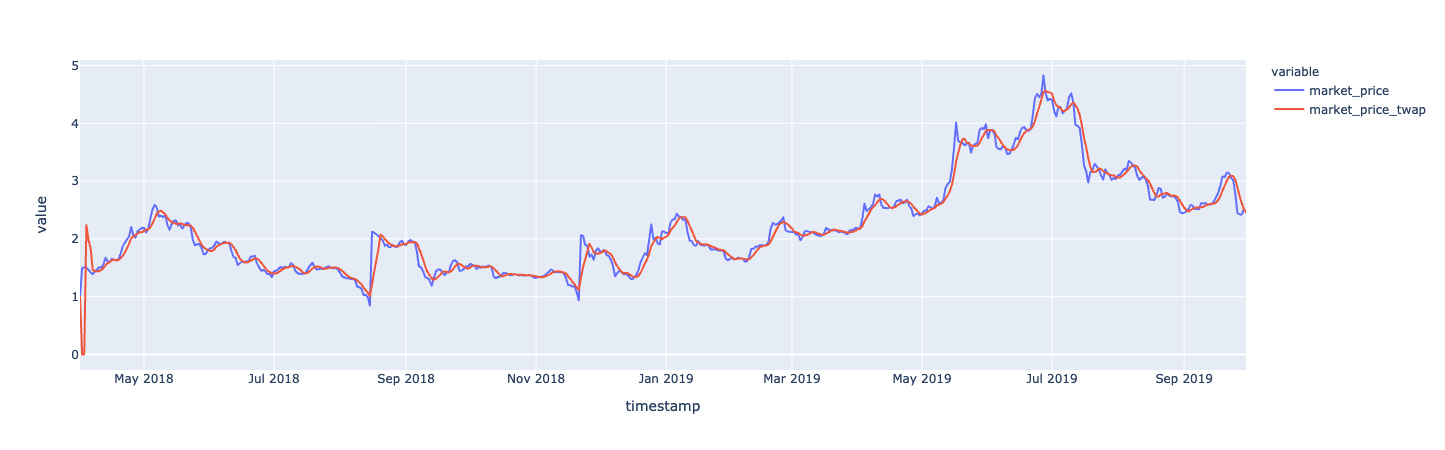

In [15]:
df.plot(x='timestamp', y=['market_price', 'market_price_twap'])

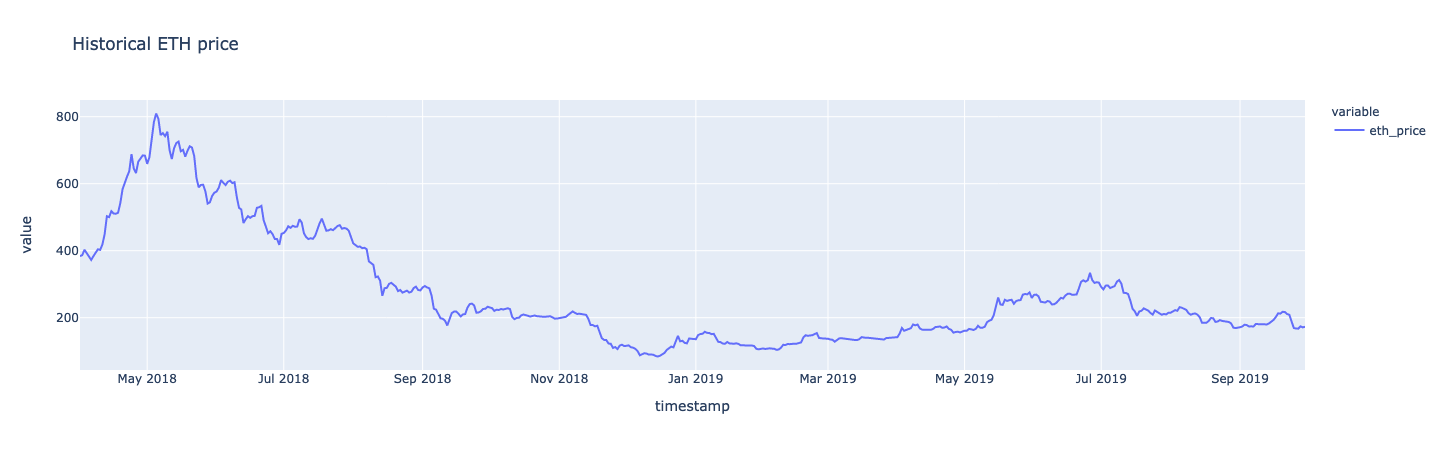

In [16]:
df.plot(x='timestamp', y=['eth_price'], title='Historical ETH price')

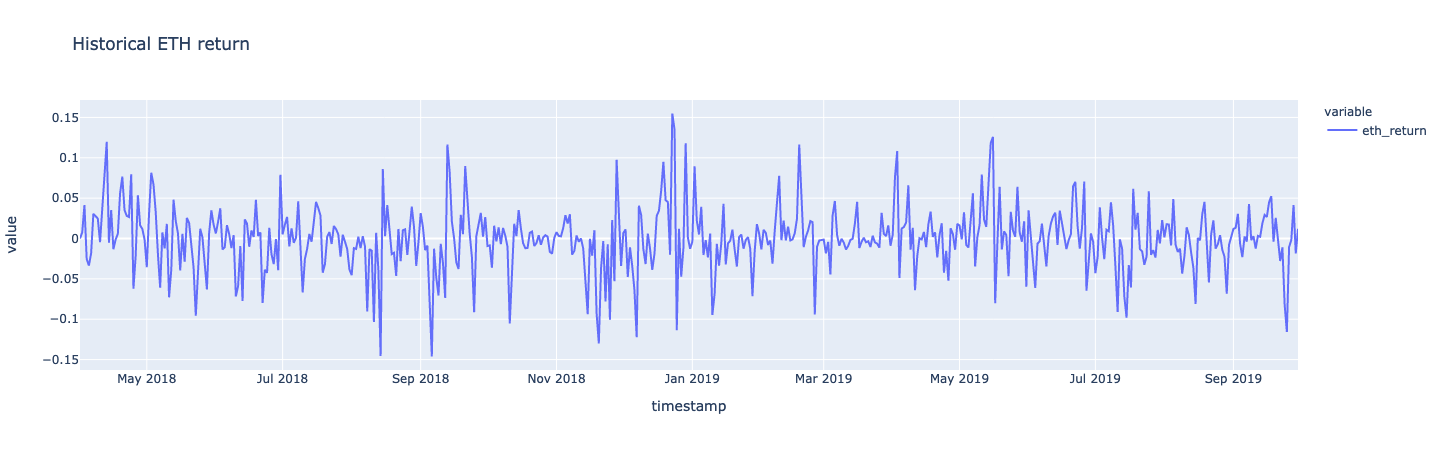

In [17]:
df.plot(x='timestamp', y=['eth_return'], title='Historical ETH return')

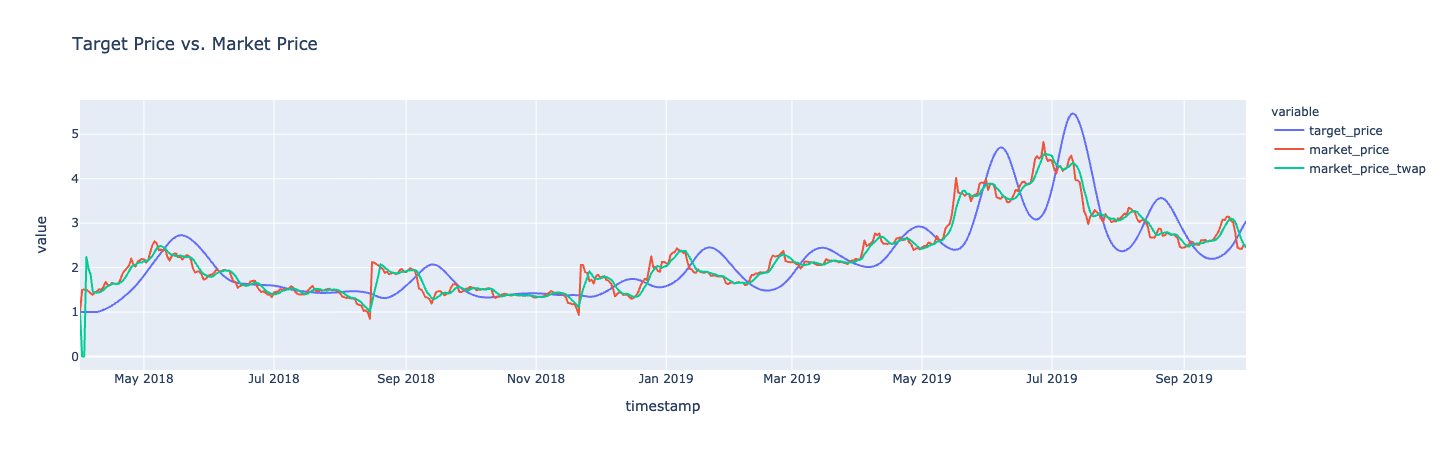

In [18]:
df.plot(x='timestamp', y=['target_price', 'market_price', 'market_price_twap'], title='Target Price vs. Market Price')

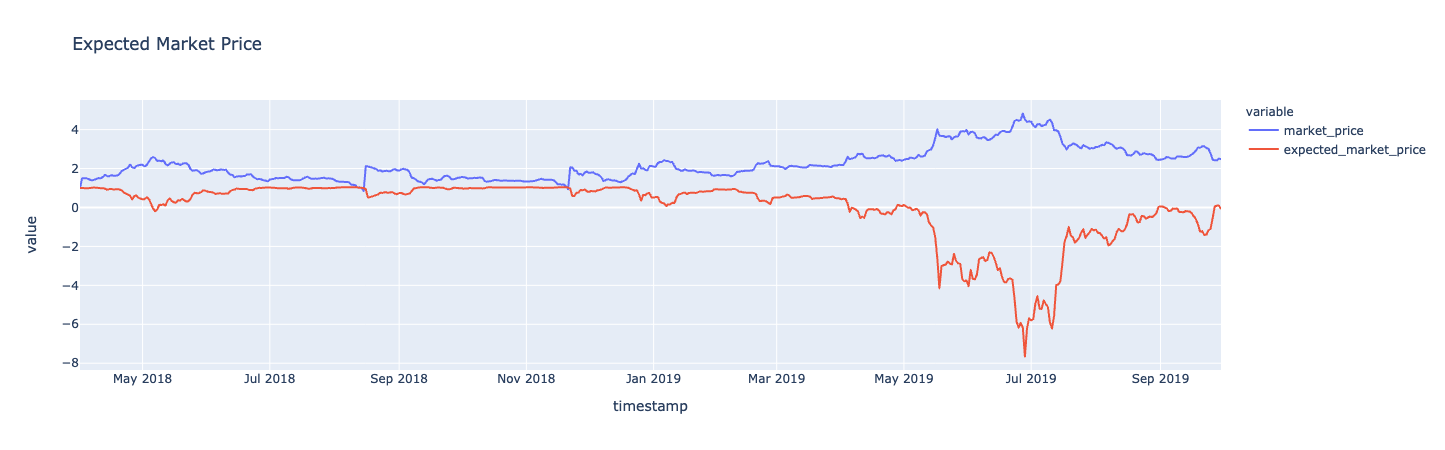

In [19]:
df.plot(x='timestamp', y=['market_price', 'expected_market_price'], title='Expected Market Price')

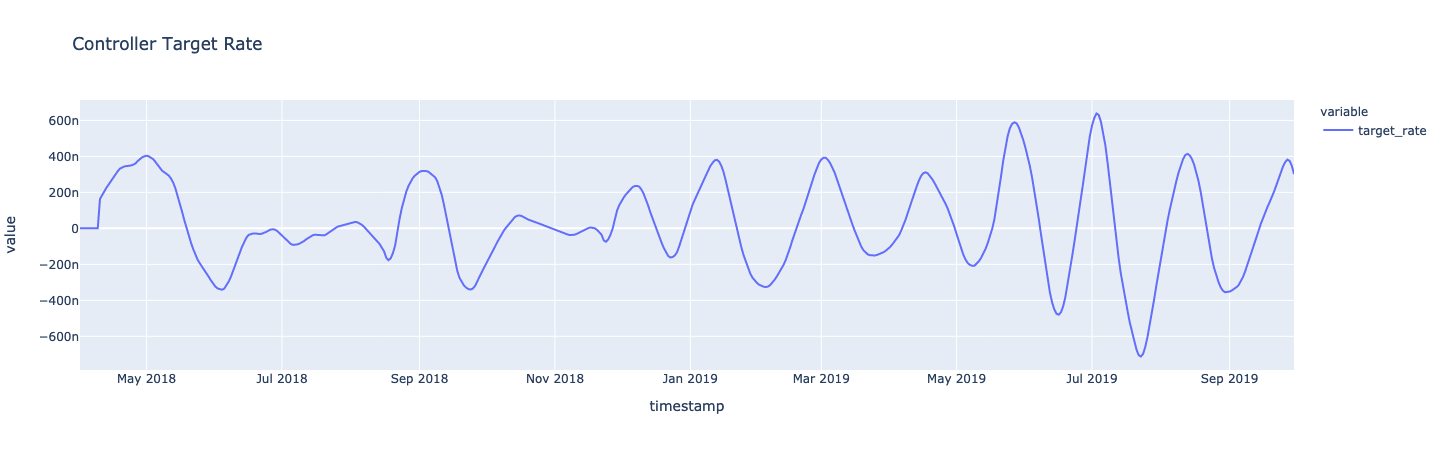

In [20]:
df.plot(x='timestamp', y=['target_rate'], title='Controller Target Rate')

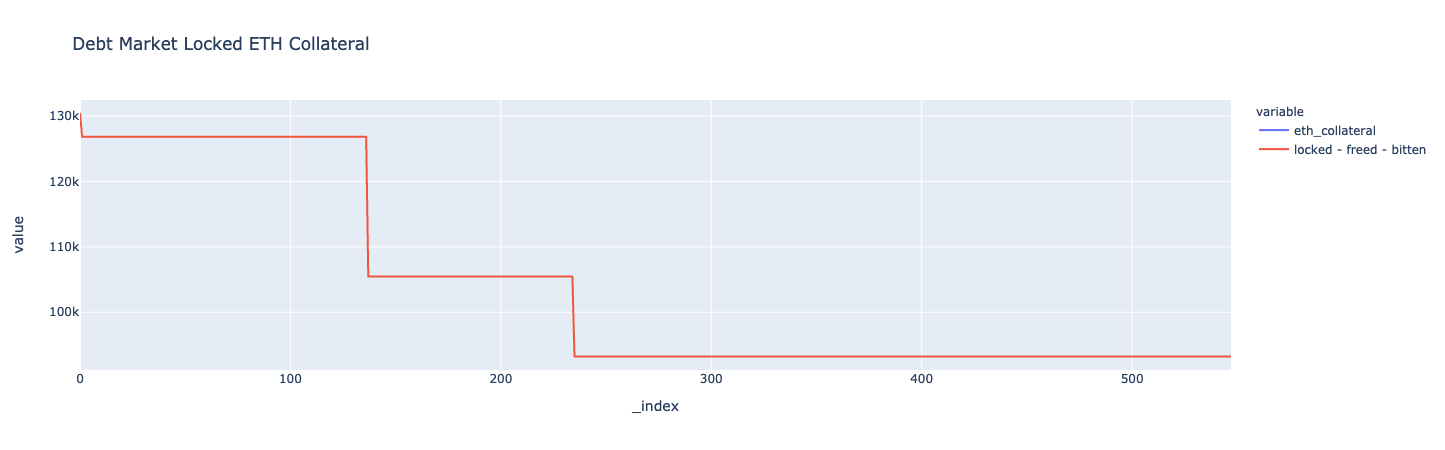

In [21]:
df['locked - freed - bitten'] = df['eth_locked'] - df['eth_freed'] - df['eth_bitten']
df.plot(y=['eth_collateral', 'locked - freed - bitten'], title='Debt Market Locked ETH Collateral')

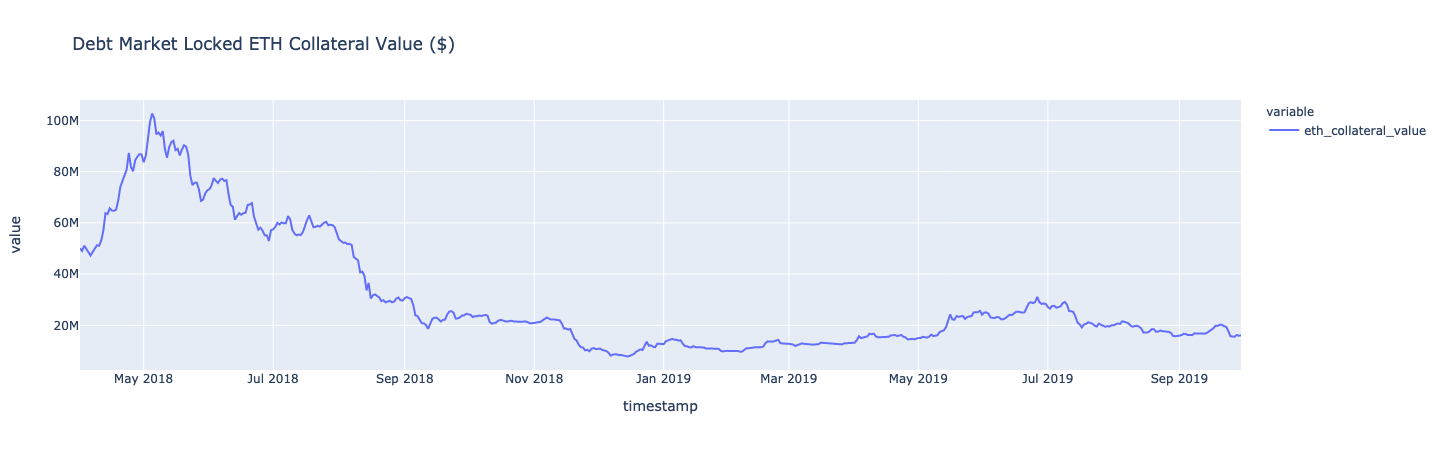

In [22]:
df.plot(x='timestamp', y=['eth_collateral_value'], title='Debt Market Locked ETH Collateral Value ($)')

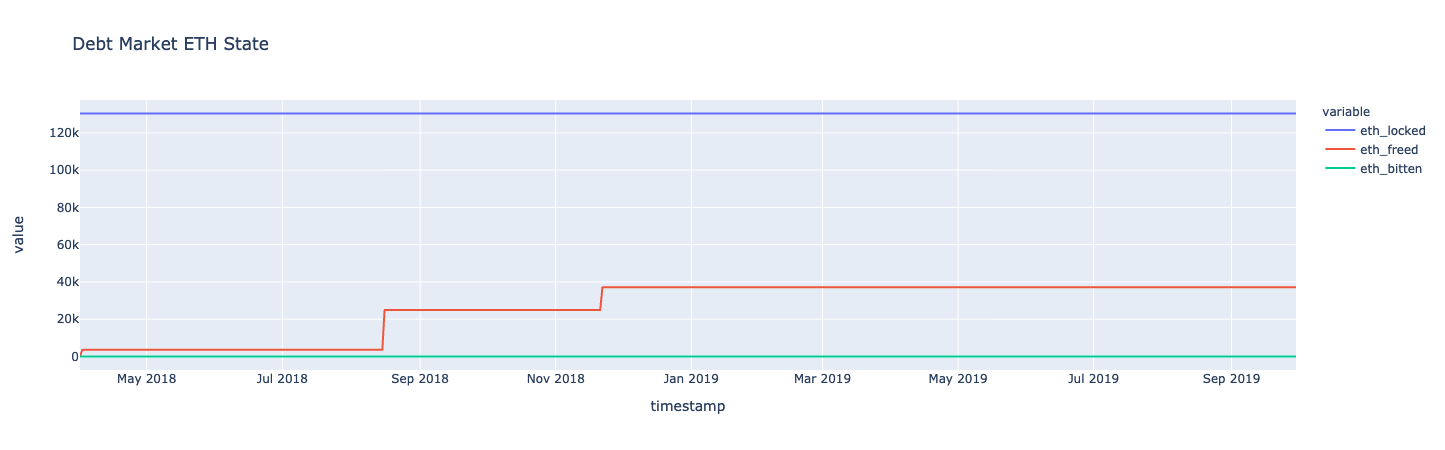

In [23]:
df.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'], title='Debt Market ETH State')

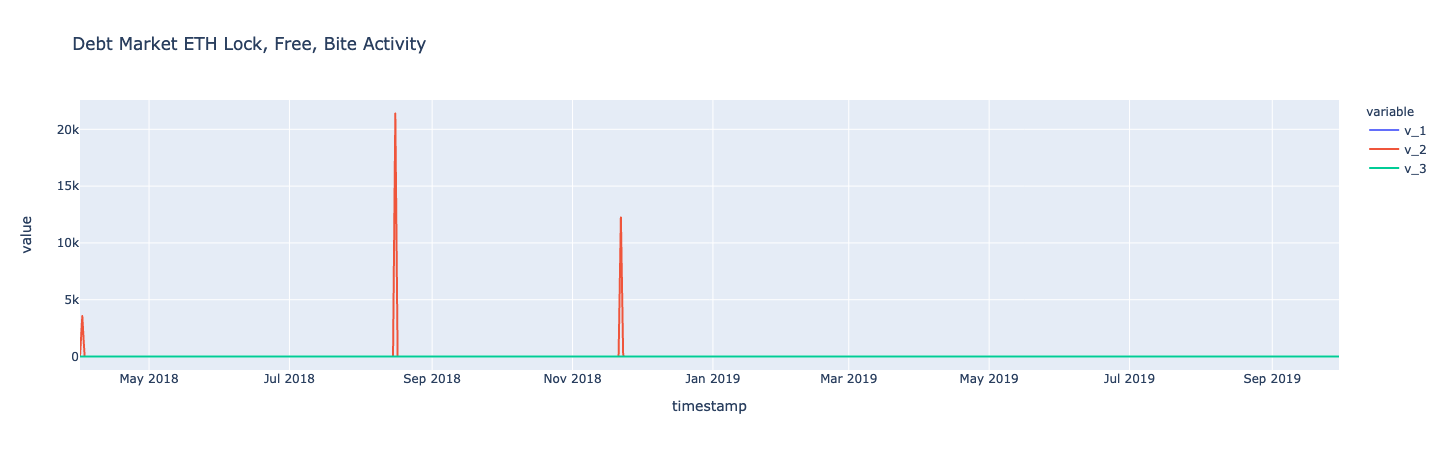

In [24]:
df.plot(x='timestamp', y=['v_1', 'v_2', 'v_3'], title='Debt Market ETH Lock, Free, Bite Activity')

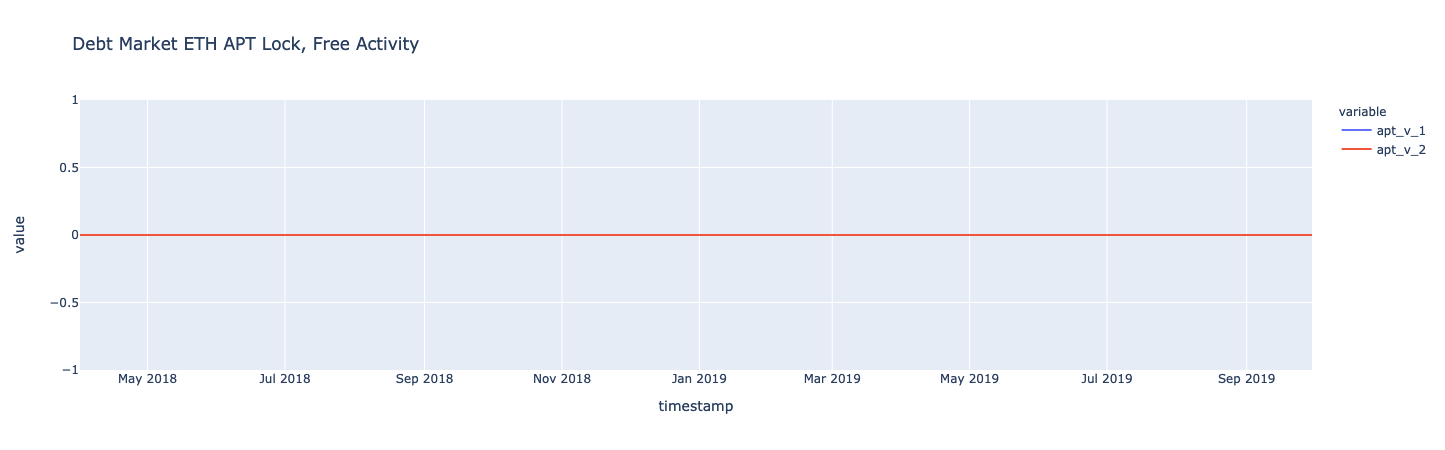

In [25]:
df['apt_v_1'] = df['optimal_values'].map(lambda v: v.get('v_1', 0))
df['apt_v_2'] = df['optimal_values'].map(lambda v: v.get('v_2 + v_3', 0))

df.plot(x='timestamp', y=['apt_v_1', 'apt_v_2'], title='Debt Market ETH APT Lock, Free Activity')

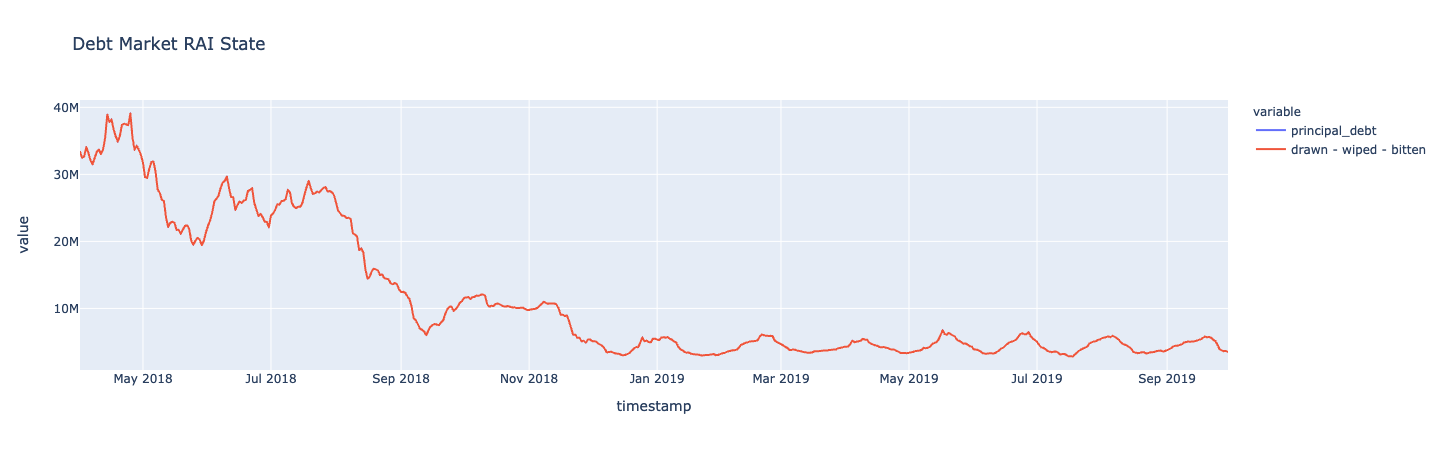

In [26]:
df['drawn - wiped - bitten'] = df['rai_drawn'] - df['rai_wiped'] - df['rai_bitten']
df.plot(x='timestamp', y=['principal_debt', 'drawn - wiped - bitten'], title='Debt Market RAI State')

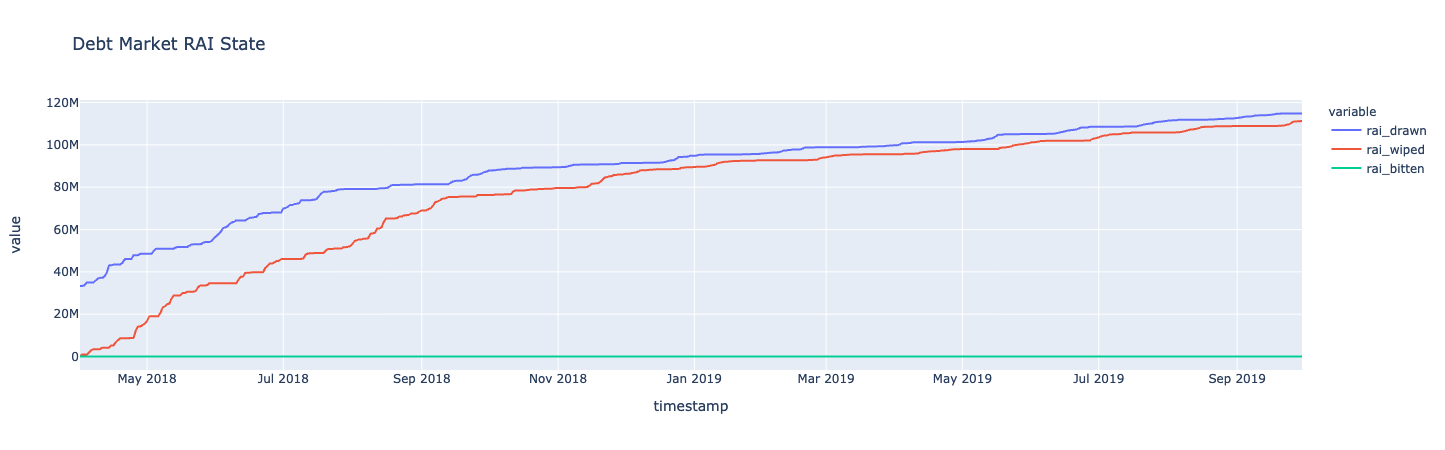

In [27]:
df.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'], title='Debt Market RAI State')

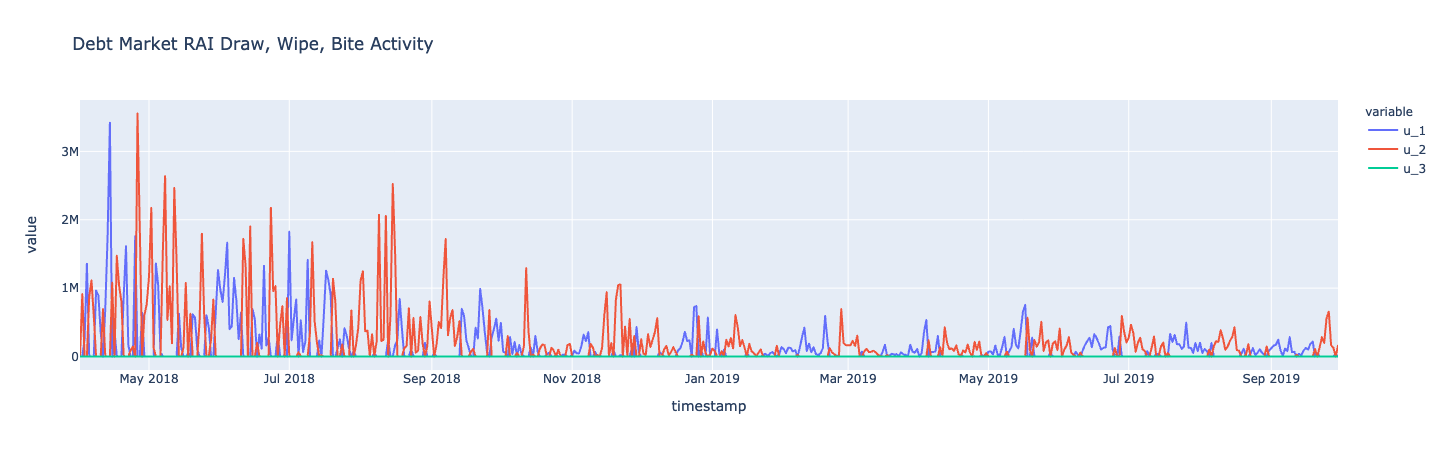

In [28]:
df.plot(x='timestamp', y=['u_1', 'u_2', 'u_3'], title='Debt Market RAI Draw, Wipe, Bite Activity')

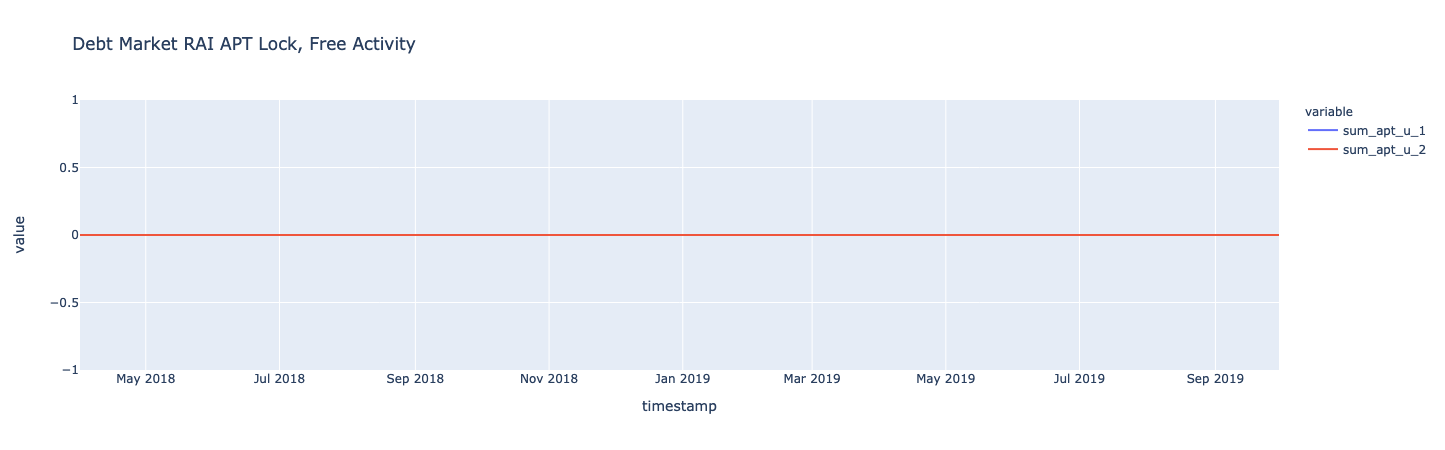

In [29]:
df['sum_apt_u_1'] = df['optimal_values'].map(lambda v: v.get('u_1', 0))
df['sum_apt_u_2'] = df['optimal_values'].map(lambda v: v.get('u_2', 0))

df.plot(x='timestamp', y=['sum_apt_u_1', 'sum_apt_u_2'], title='Debt Market RAI APT Lock, Free Activity')

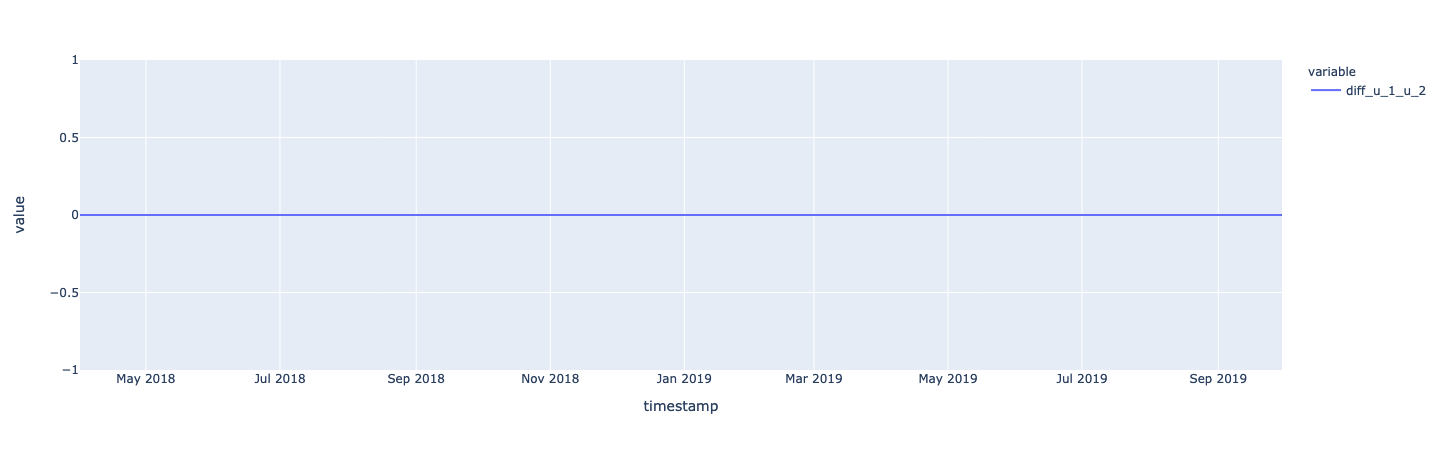

In [30]:
df['diff_u_1_u_2'] = df['sum_apt_u_1'] - df['sum_apt_u_2']
df['diff_u_1_u_2'] = df['diff_u_1_u_2'].cumsum()

df.plot(x='timestamp', y=['diff_u_1_u_2'])

## Accrued interest and system revenue

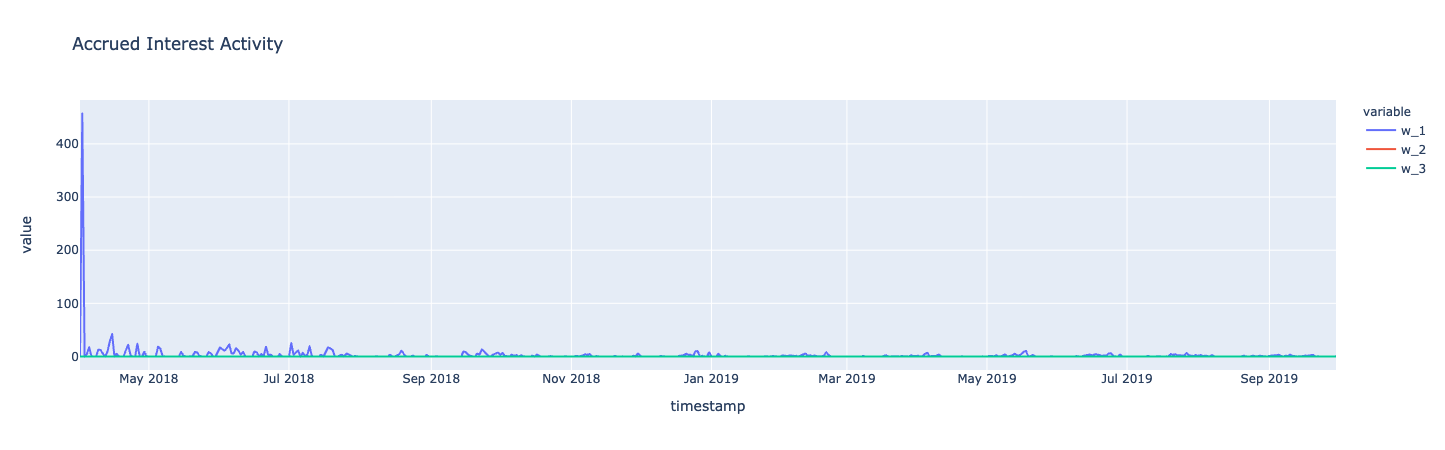

In [31]:
df.plot(x='timestamp', y=['w_1', 'w_2', 'w_3'], title='Accrued Interest Activity')

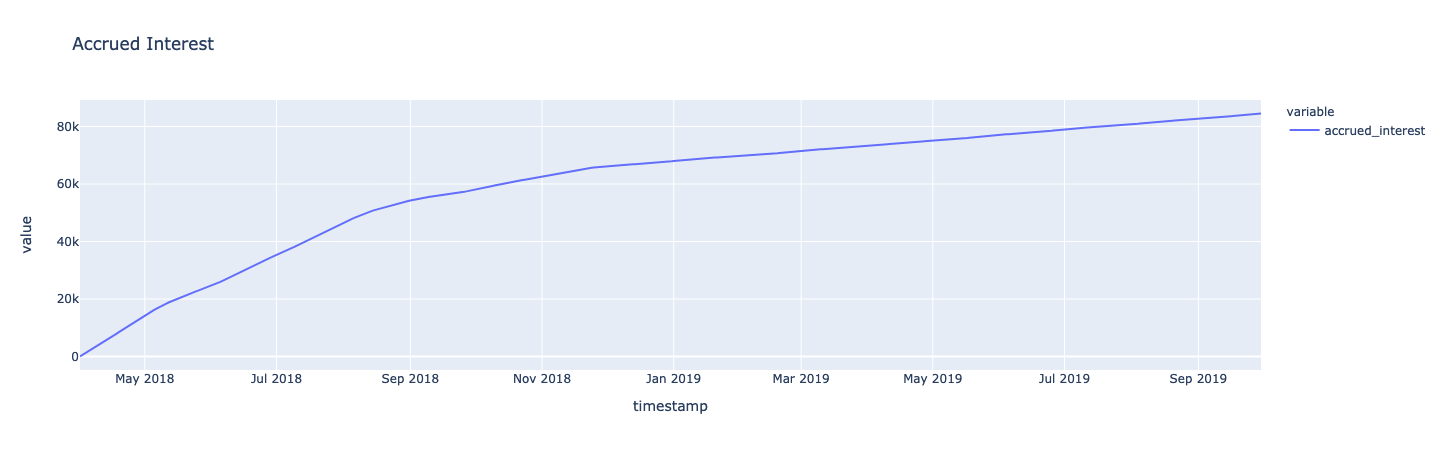

In [32]:
df.plot(x='timestamp', y=['accrued_interest'], title='Accrued Interest')

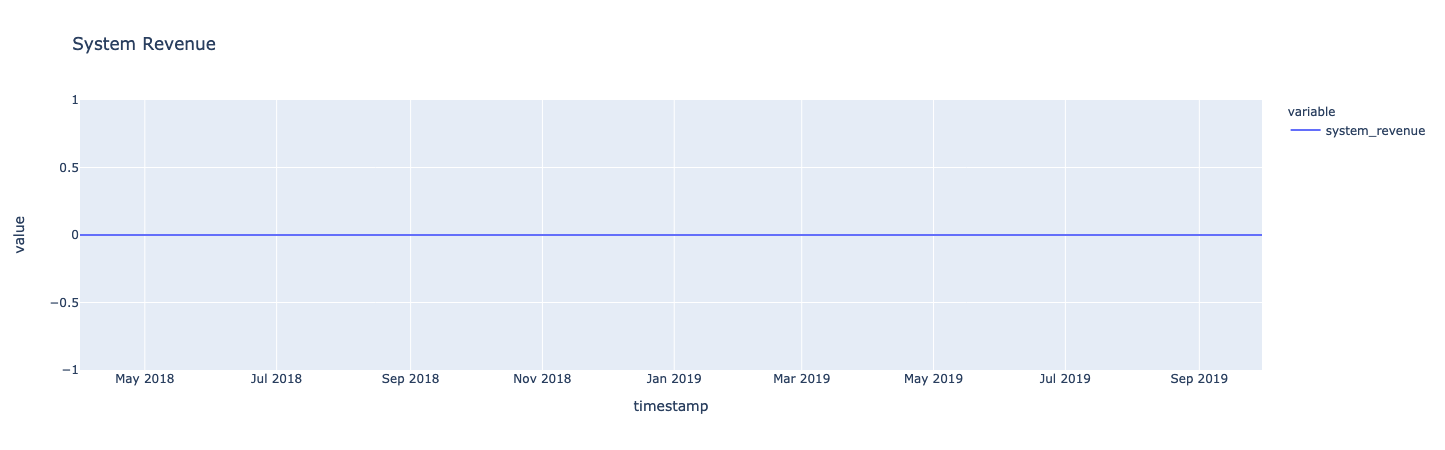

In [33]:
df.plot(x='timestamp', y=['system_revenue'], title='System Revenue')

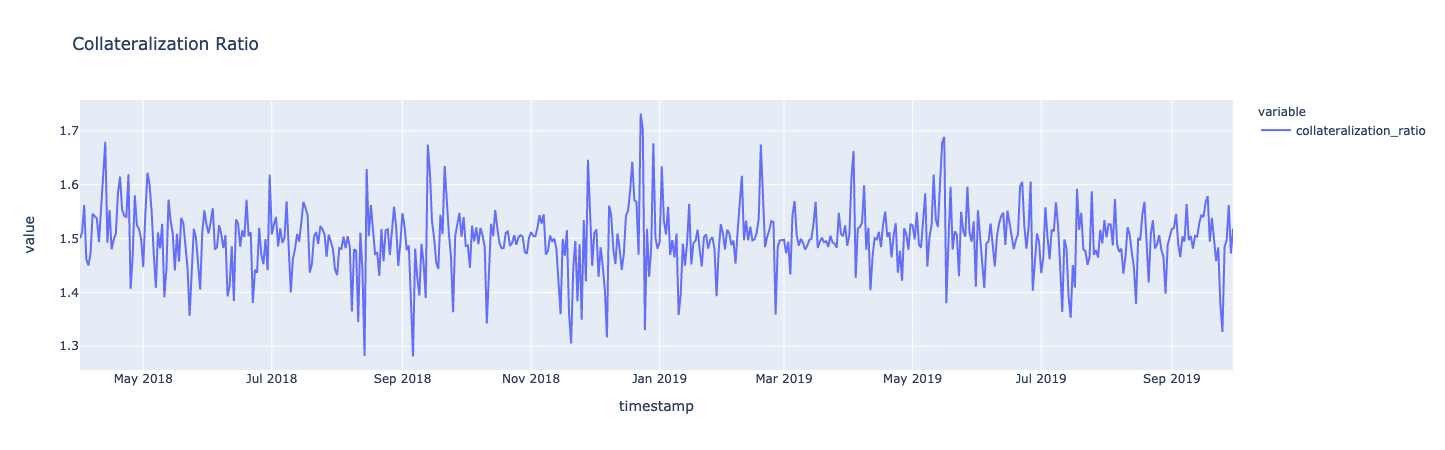

In [34]:
df.plot(x='timestamp', y=['collateralization_ratio'], title='Collateralization Ratio')

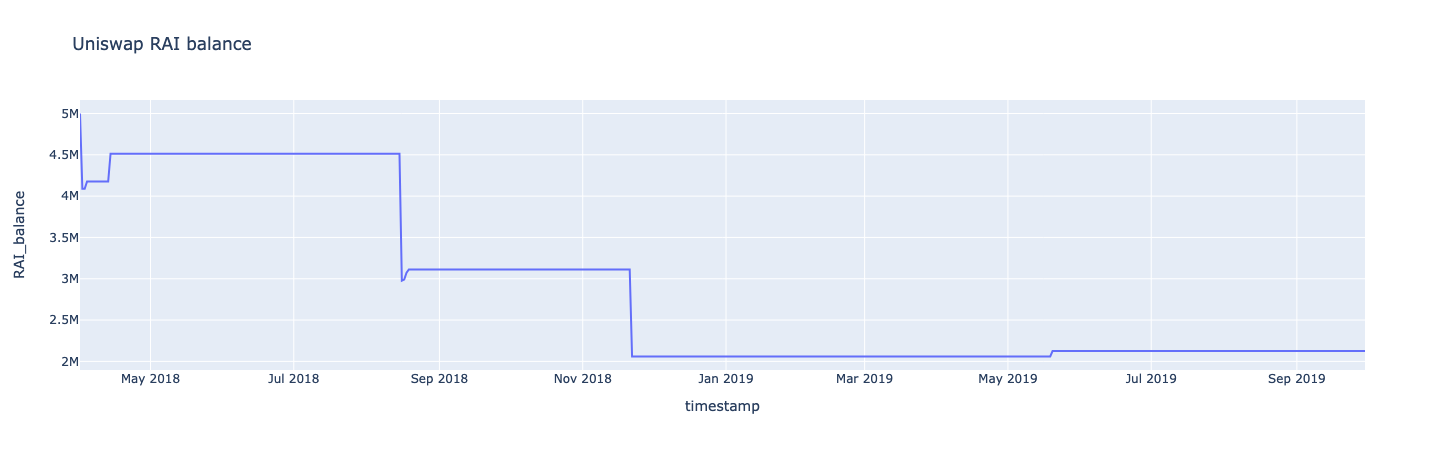

In [35]:
df.plot(x='timestamp', y='RAI_balance', title='Uniswap RAI balance')

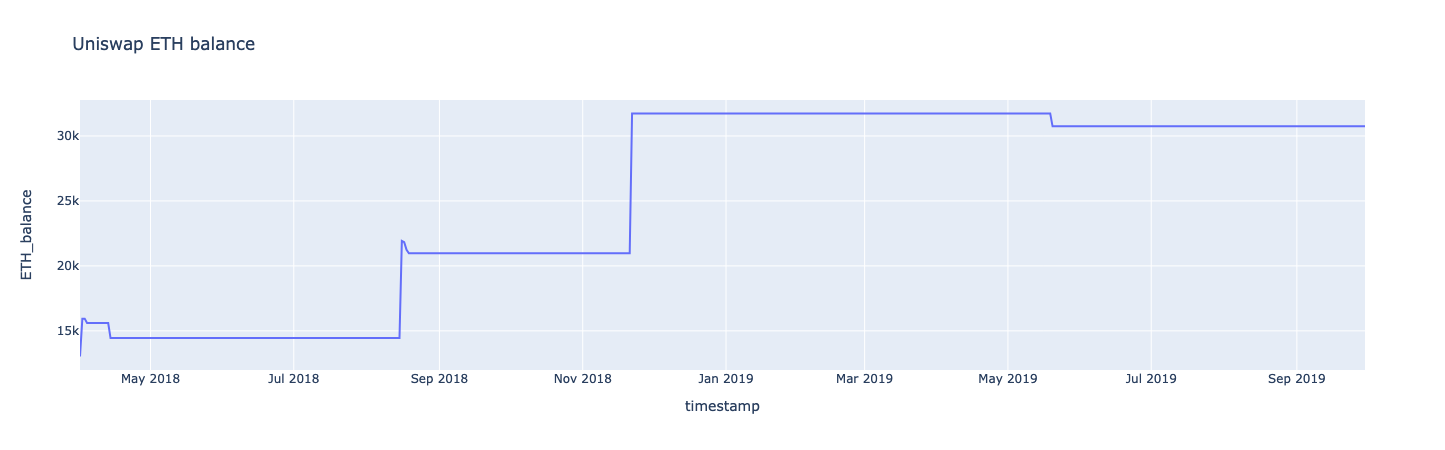

In [36]:
df.plot(x='timestamp', y='ETH_balance', title='Uniswap ETH balance')

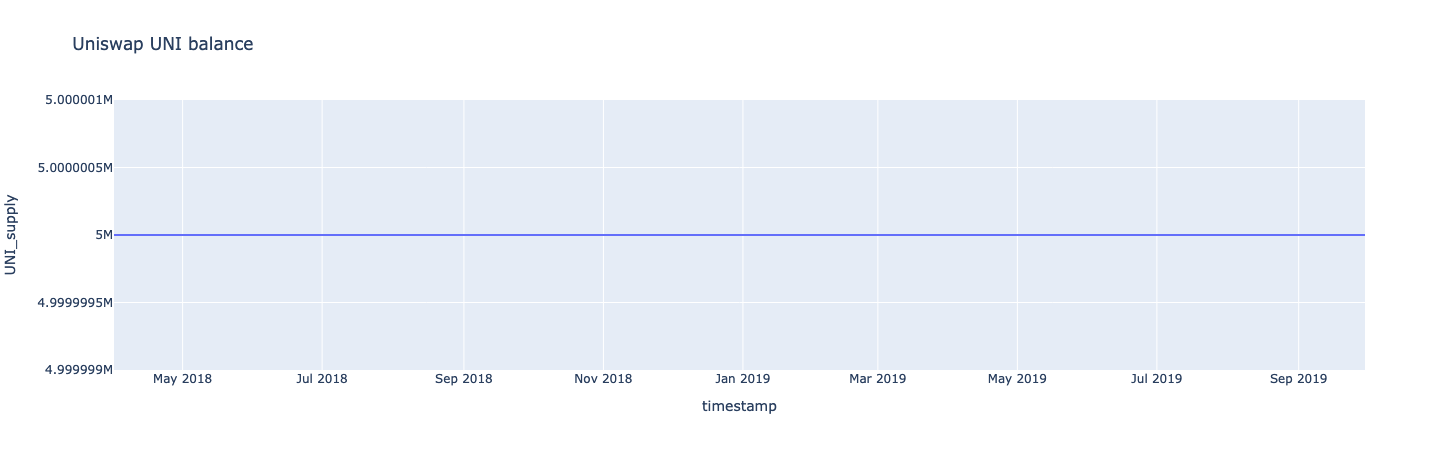

In [37]:
df.plot(x='timestamp', y='UNI_supply', title='Uniswap UNI balance')

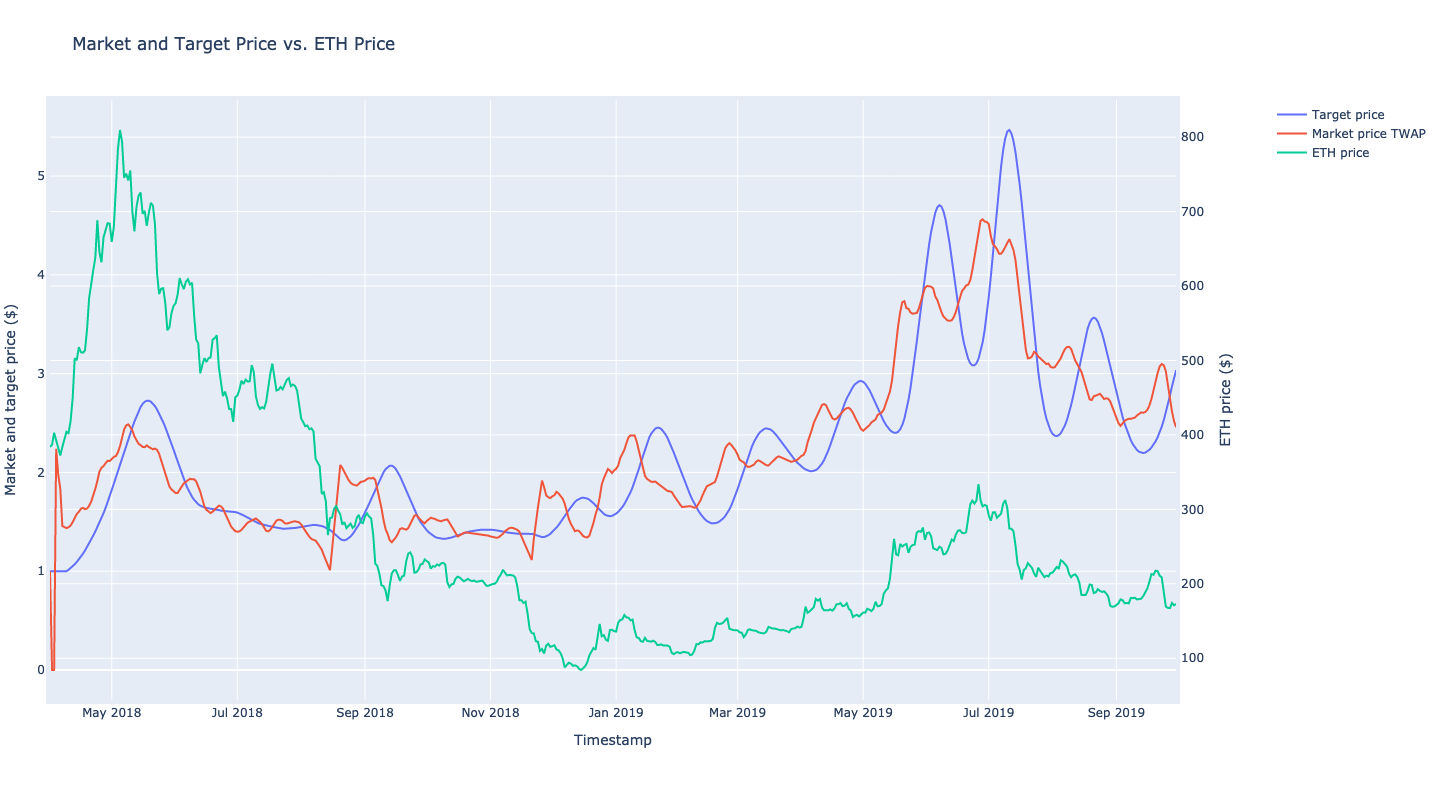

In [38]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Target price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price_twap'], name="Market price TWAP"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['eth_price'], name="ETH price"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Market and Target Price vs. ETH Price"
)

# Set x-axis title
fig.update_xaxes(title_text="Timestamp")

# Set y-axes titles
fig.update_yaxes(title_text="Market and target price ($)", secondary_y=False)
fig.update_yaxes(title_text="ETH price ($)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

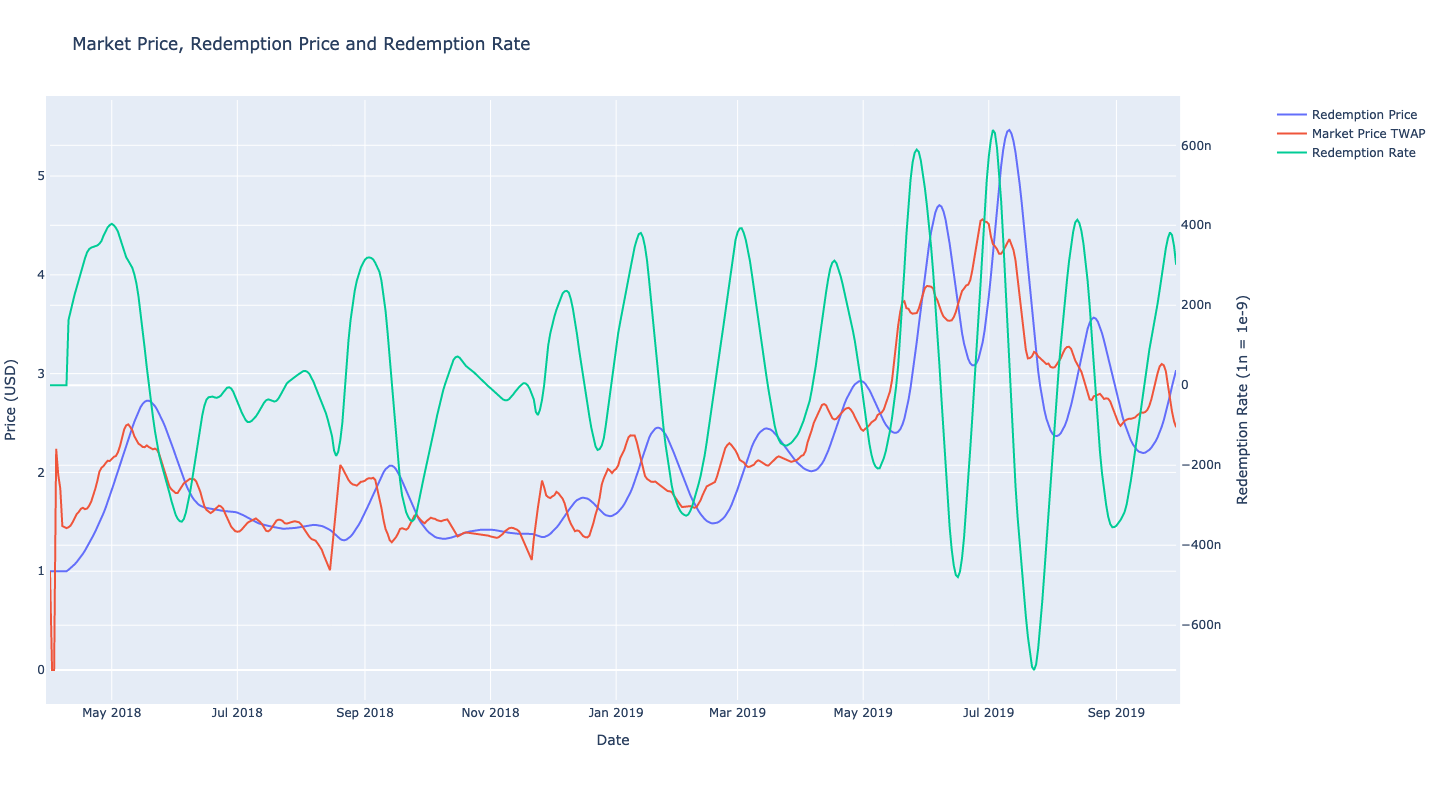

In [39]:

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Redemption Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price_twap'], name="Market Price TWAP"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_rate'], name="Redemption Rate"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Market Price, Redemption Price and Redemption Rate"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Redemption Rate (1n = 1e-9)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

## Simulation statistics

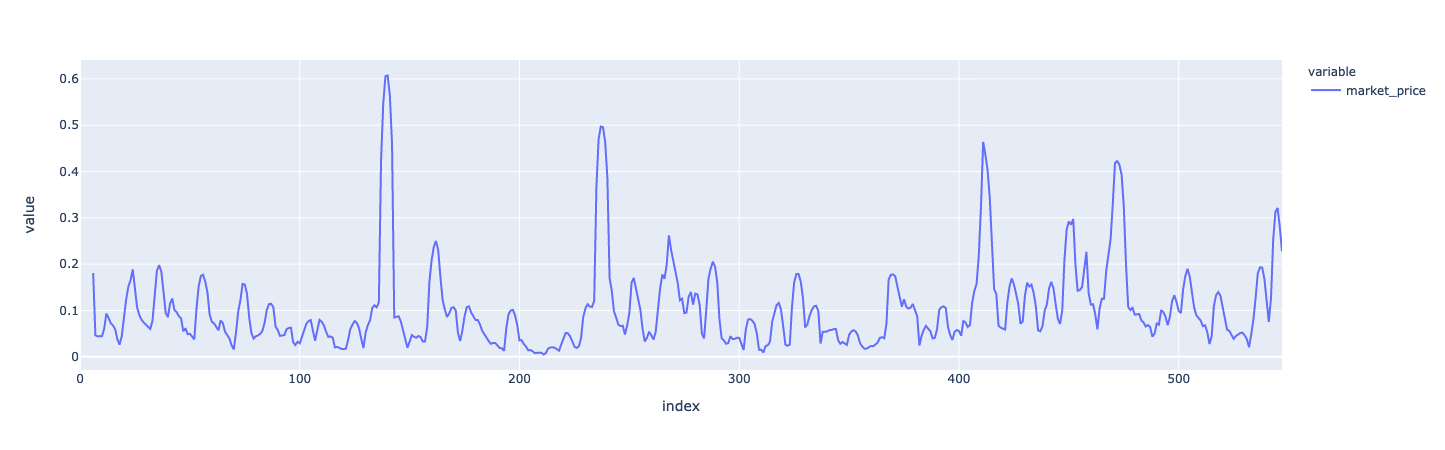

In [40]:
std_mkt = df['market_price'].rolling(7).std()
std_mkt.plot()

In [41]:
np.std(df['market_price'])

0.815312133978043

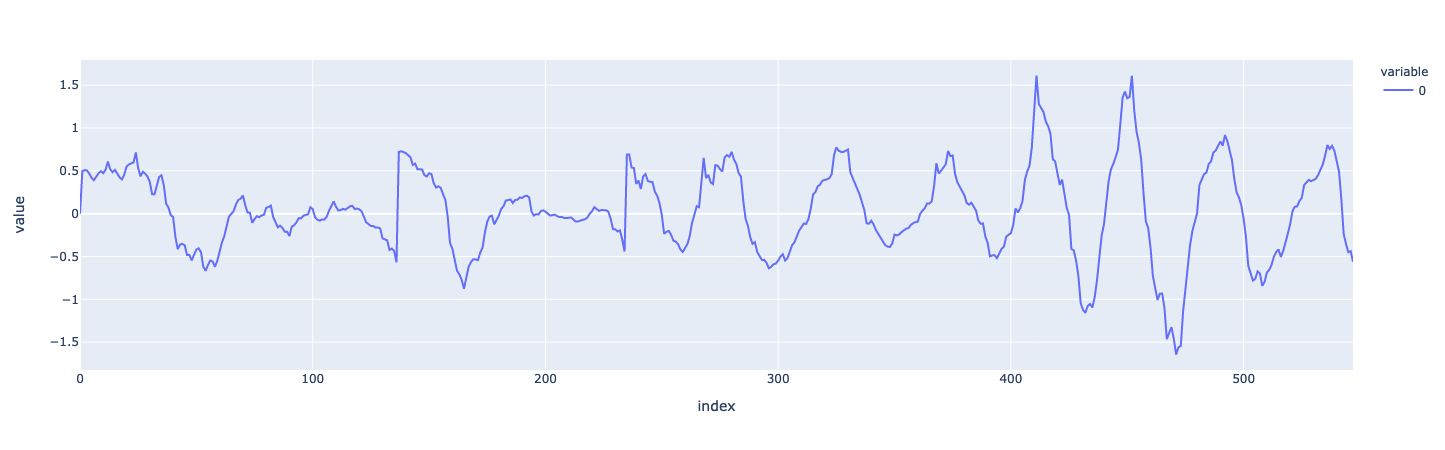

In [42]:
err_m_t = df['market_price'] - df['target_price']
err_m_t.plot()

In [43]:
np.sqrt(abs(df['market_price'] - df['target_price']).mean())

0.6241203801577063

In [44]:
np.corrcoef(df['market_price'],df['eth_price'])

array([[ 1.        , -0.08418179],
       [-0.08418179,  1.        ]])

In [45]:
np.corrcoef(df['market_price'],df['target_price'])

array([[1.        , 0.83264068],
       [0.83264068, 1.        ]])

In [46]:
np.corrcoef(df['market_price'],df['target_rate'])

array([[1.        , 0.14822422],
       [0.14822422, 1.        ]])

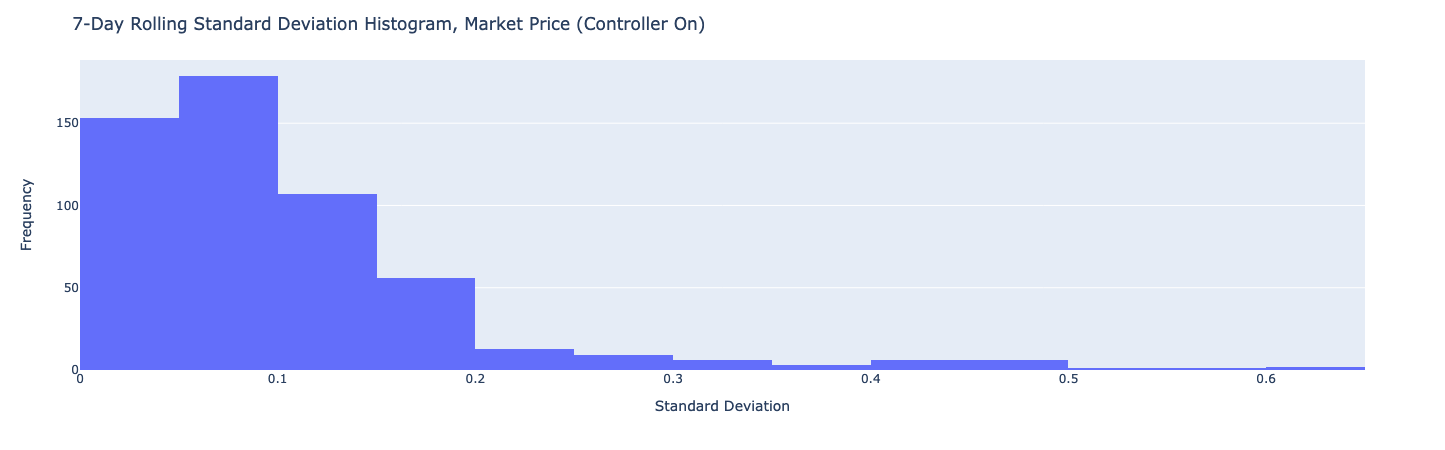

In [47]:

df['market_price_rolling'] = df['market_price'].rolling(7).std()
fig = px.histogram(df, x="market_price_rolling", nbins=25)

fig.update_layout(
    title="7-Day Rolling Standard Deviation Histogram, Market Price (Controller On)",
    xaxis_title="Standard Deviation",
    yaxis_title="Frequency",
)

fig.show()

In [48]:

# std_mkt_without = res_without_controller[‘market_price’].rolling(7).std()
# std_mkt_with = res_with_controller[‘market_price’].rolling(7).std()
# df =pd.DataFrame(dict(
#     series=np.concatenate(([“With Controller”]*len(std_mkt_with), [“Without Controller”]*len(std_mkt_without))),
#     data  =np.concatenate((std_mkt_with,std_mkt_without))
# ))

# fig = df.hist(x=“data”, color=“series”, nbins=25, barmode=“overlay”,
#         labels={
#             ‘count’ : “Count”,
#             ‘data’ : “Std Dev”,
#             ‘series’ : “Simulation”
#         },
#         title=“Histogram, Standard Deviations of Market Price”)
# fig.show()